In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation
from tqdm.notebook import tqdm

In [3]:
FRAME_DOWNSAMPLING = 1

In [4]:
def get_wave(t, f):
    dt = np.full_like(t, t[1] - t[0])
    phases = np.cumsum(f * 2 * np.pi * dt)

    return np.sin(phases), ((phases + np.pi) % (2 * np.pi) - np.pi)


def setup_time_axes(start, end):
    fig, ax = plt.subplots(1, 1, figsize = (20, 4), dpi = 300)
    fig.set_facecolor("black")
    ax.set_facecolor("black")
    ax.set_xlim(start - 0.1, end + 0.1)
    ax.set_ylim(-1.1, 1.1)
    ax.grid(color = "white", linewidth = 0.4, alpha = 0.3, zorder = 0)

    return (fig, ax)


def plot_line_collection_axis(ax, x, y, color = "white", alpha = 1, **kwargs):
    line_collection = LineCollection(make_segments(x, y), **kwargs)
    line_collection.set_colors(color)
    line_collection.set_alpha(alpha)
    line_collection.set_capstyle("round")
    ax.add_collection(line_collection)

    return line_collection


def animate_line_collections(line_collections, fig, fills = None, only_fills = False, frame_downsampling = 1, ax = None):
    x = []
    y = []

    if not ax is None:
        for lc in line_collections:
            segs = lc.get_segments()
            x.append(np.array([seg[0, 0] for seg in segs]))
            x.append(np.array([seg[0, 1] for seg in segs]))
        
        def animate(play_time):
            for k, lc in enumerate(line_collections):
                lc.set_alpha(x[k] <= play_time)
            
            if fills is None:
                return (line_collections, )

            mask_condition = x[0] >= play_time
            x_masked = np.ma.masked_where(mask_condition, x[0])
            ax.collections.clear()

            for k, fill in enumerate(fills):
                y_masked = np.ma.masked_where(mask_condition, y[k])
                fills[k] = ax.fill_between(x_masked, 0, y_masked, color = fill.get_facecolor(), alpha = fill.get_alpha())
        
            if not only_fills:
                ax.add_collection(lc)
            
            return (line_collections, fills)
    
    return FuncAnimation(fig, animate, frames = tqdm(x[0][::frame_downsampling]), interval = 30)



def angle_2_color(angle):
    phase_colormap = sns.color_palette("hls", as_cmap = True)
    return phase_colormap((angle % (2 * np.pi)) / (2 * np.pi))


def make_segments(x, y):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    return np.concatenate([points[:-1], points[1:]], axis = 1)



In [5]:
n = 5000
t_start = 0
t_end = 5
time = np.linspace(t_start, t_end, n)

generator = np.random.default_rng(seed = 322)
x_samples = np.linspace(t_start, t_end, 10)
f_samples = generator.random(x_samples.shape) * 6
interpolation = interp1d(x_samples, f_samples, kind = "quadratic")
freq = interpolation(time)

wave, phase = get_wave(time, freq)

  0%|          | 0/4999 [00:00<?, ?it/s]

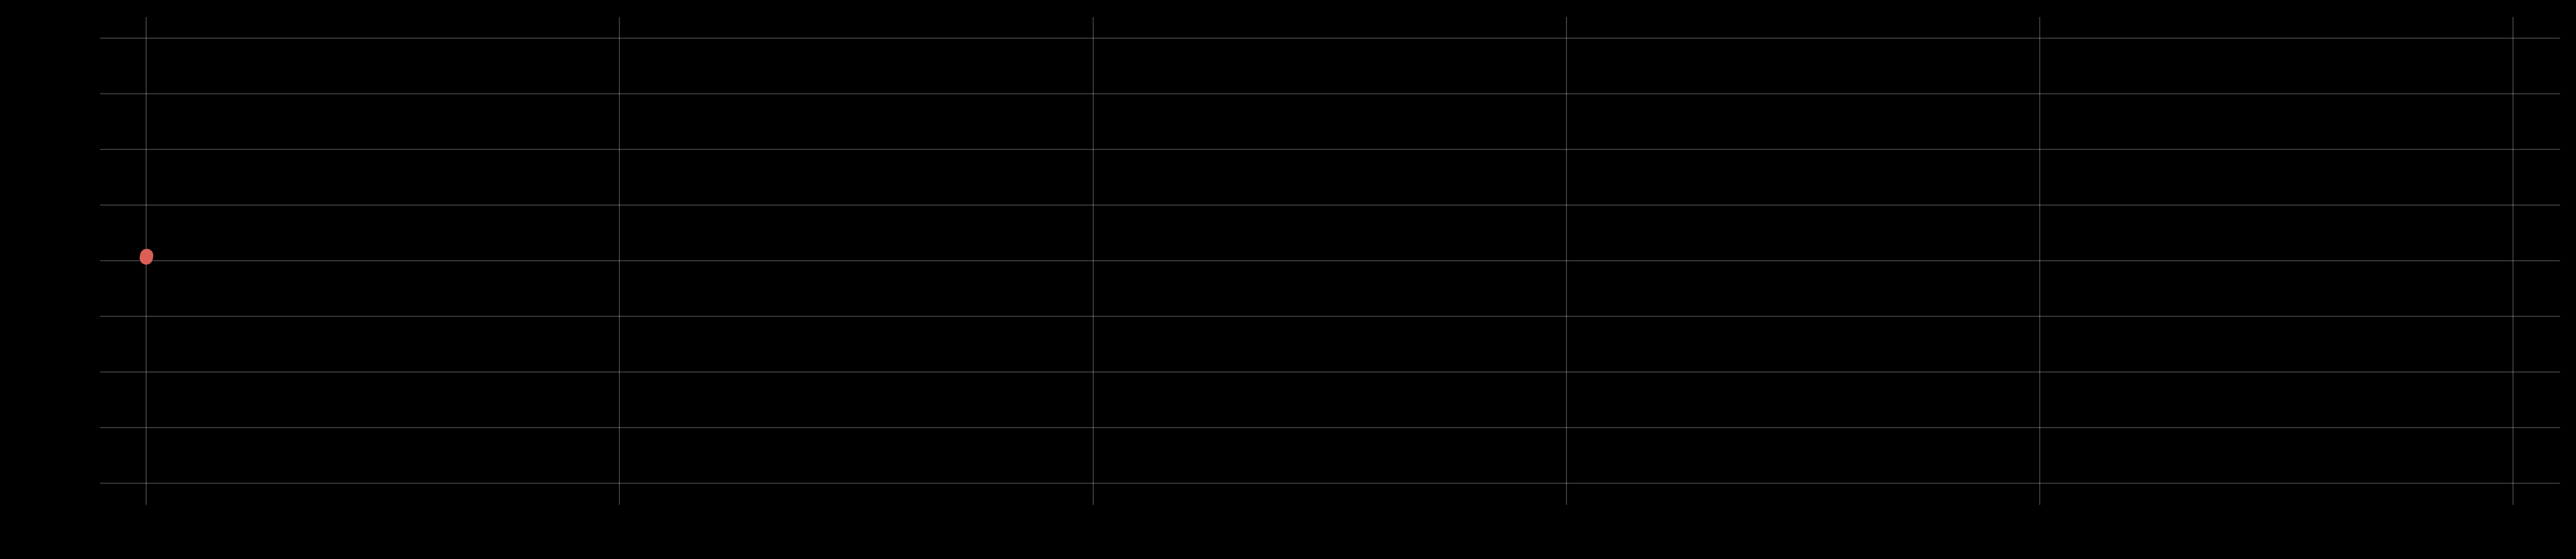

In [7]:
fig, ax = setup_time_axes(t_start, t_end)

line_collection = plot_line_collection_axis(ax, time, wave, angle_2_color(phase[:-1]), linewidths = 6)
animation = animate_line_collections([line_collection], fig, frame_downsampling = FRAME_DOWNSAMPLING, ax = ax)
animation.save("./renders/Drawing a phase-colored wave.mp4")